## Gerekli kütüphaneleri içe aktar
Görüntü işleme (PIL, matplotlib, numpy) ve PyTorch + torchvision model yükleme işlemleri için gerekli kütüphaneleri yüklüyoruz.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import models, transforms
from PIL import Image

## Cihazı ayarla (GPU varsa kullan)
CUDA destekli bir ekran kartın varsa, modeli GPU'ya, yoksa CPU kullanacak.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Pretrained DeepLabV3 Modelini yükle ve cihaza taşı
DeepLabV3+ modeli, önceden eğitilmiş ağırlıklarla (pretrained=True) yüklendi. eval() ile inference moduna geçtik.

In [3]:
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model = model.to(device)
model.eval()

/home/bilal/miniconda3/envs/pt/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bilal/miniconda3/envs/pt/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## Görüntüyü yükle ve dönüştür
Resmi açıyoruz, 512x512 boyutuna getiriyoruz. Modelin istediği şekilde normalize edip tensöre çeviriyoruz. unsqueeze(0) ile batch boyutu ekliyoruz.

In [4]:
img = Image.open("../resimler/kedi-köpek.jpg").convert("RGB").resize((512, 512))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

input_tensor = transform(img).unsqueeze(0).to(device)

## Model ile tahmin yap
no_grad() kullanarak modelden çıktı alıyoruz (backprop yok). Çıktıdaki her piksel için en yüksek skora sahip sınıfı (argmax) alıyoruz → segmentasyon maskesi.

In [5]:
with torch.no_grad():
    output = model(input_tensor)

output_mask = output['out'][0]
predicted_mask = output_mask.argmax(0)

## Orijinal resim ve segmentasyon maskesini görselleştir
Yan yana iki grafik çiziyoruz: biri orijinal resim, diğeri modelin ürettiği segmentasyon maskesi.

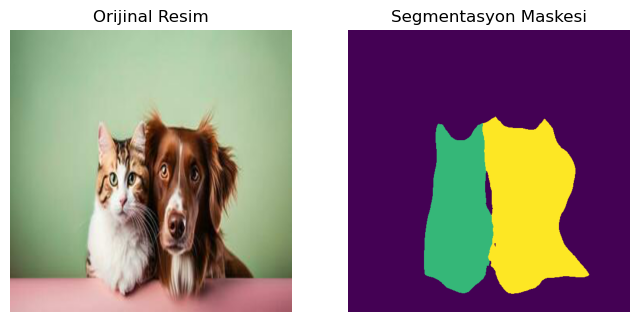

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(np.array(img))
axes[0].set_title("Orijinal Resim")
axes[0].axis('off')

axes[1].imshow(predicted_mask.cpu().numpy())
axes[1].set_title("Segmentasyon Maskesi")
axes[1].axis('off')

plt.show()

## Arka plan, kedi+köpek ve köpek maskelerini ayrı ayrı göster

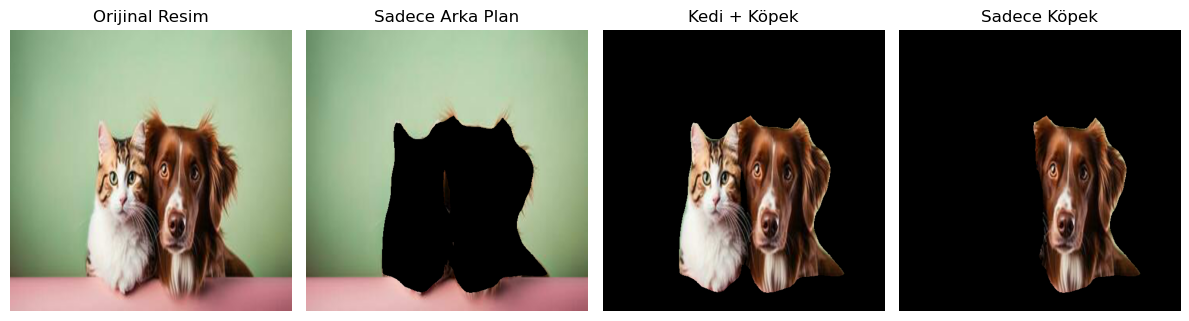

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4)) 

axes[0].imshow(np.array(img))
axes[0].set_title("Orijinal Resim")
axes[0].axis('off')

background_mask = (predicted_mask.cpu().numpy() == 0)
background_image = np.array(img) * np.expand_dims(background_mask, axis=-1)
axes[1].imshow(background_image)
axes[1].set_title("Sadece Arka Plan")
axes[1].axis('off')

cat_mask = (predicted_mask.cpu().numpy() == 8)  # Kedi sınıfı
dog_mask = (predicted_mask.cpu().numpy() == 12) # Köpek sınıfı
combined_mask = np.logical_or(cat_mask, dog_mask)
image_without_background = np.array(img) * np.expand_dims(combined_mask, axis=-1)
axes[2].imshow(image_without_background)
axes[2].set_title("Kedi + Köpek")
axes[2].axis('off')

dog_image = np.array(img) * np.expand_dims(dog_mask, axis=-1)
axes[3].imshow(dog_image)
axes[3].set_title("Sadece Köpek")
axes[3].axis('off')

plt.tight_layout()
plt.show()
